# ML Classifier Copies - Room Occupancy Detection Model Example

An example where we take an existing "black box" classifier model of the publicly available [Room Occupancy Detection dataset](https://archive-beta.ics.uci.edu/ml/datasets/occupancy+detection), that we can query in order to obtain a copy.

Since we don't know the orginal model family, we will build several copies from different model families and compare the copy fidelity and performance.

(NOTE: Since we **did** build this model, we do have in fact all information.)

<a name="Index">
    
----
# Table of contents

    
1. [**Load original model**](#Original)
2. [**Build copies**](#Copies)
3. [**Evaluate copies**](#Evaluation)
----

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import sys
sys.path.append("../")

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from presc.dataset import Dataset
from presc.copies.copying import ClassifierCopy
from presc.copies.sampling import grid_sampling, normal_sampling, spherical_balancer_sampling, labeling
from ML_copies_original_models import WinesModel, OccupancyModel, SegmentationModel

[Index](#Index)  
  
  


<a name="Original">  

-----
-----
# Load original model

In [14]:
occupancy_model = OccupancyModel()

[Index](#Index)  
  
  


<a name="Copies">  

-----
# Build copies

In [15]:
log_normal_classifier = Pipeline([('scaler', StandardScaler()), ('log_classifier', 
                                   LogisticRegression())])
knn_normal_classifier = Pipeline([('scaler', StandardScaler()), ('KKN_classifier', 
                                KNeighborsClassifier(n_neighbors=30, weights="distance"))])
svm_normal_classifier = Pipeline([('scaler', StandardScaler()), ('SVC_classifier', SVC(kernel="linear"))])

We will assume that we don't know anything about the distribution of the numerical features, but that we can normalize them as a pre-processing step before training the model and thus force them to be centered at 0 and have a standard deviation of 1.

In [16]:
feature_description = occupancy_model.feature_description

In [21]:
balance_parameters={"max_iter": 50, "nbatch": 1500, "verbose": False}
log_normal_copy = ClassifierCopy(occupancy_model.model, log_normal_classifier, normal_sampling,
                                 enforce_balance=False, nsamples=2000, random_state=42,
                                 feature_parameters=feature_description, label_col="Occupancy",
                                 **balance_parameters)
log_normal_copy_training_data = log_normal_copy.copy_classifier(get_training_data=True)

knn_normal_copy = ClassifierCopy(occupancy_model.model, knn_normal_classifier, normal_sampling,
                                  enforce_balance=False, nsamples=2000, random_state=42,
                                  feature_parameters=feature_description, label_col="Occupancy",
                                  **balance_parameters) 
knn_normal_copy_training_data = knn_normal_copy.copy_classifier(get_training_data=True)

svm_normal_copy = ClassifierCopy(occupancy_model.model, svm_normal_classifier, normal_sampling,
                                 enforce_balance=False, nsamples=2000, random_state=42,
                                 feature_parameters=feature_description, label_col="Occupancy",
                                 **balance_parameters) 
svm_normal_copy_training_data = svm_normal_copy.copy_classifier(get_training_data=True)

[Index](#Index)  
  
  


<a name="Evaluation">  

-----
# Evaluate copies
    
### Evaluation summary

In [23]:
print("\n * Logistic regression copy:")
synthetic_log_normal_test_data = log_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_log_normal_copy = log_normal_copy.evaluation_summary(test_data=Dataset(
                                                occupancy_model.X_test.join(occupancy_model.y_test), label_col="Occupancy"), 
                                                                  synthetic_data=synthetic_log_normal_test_data)

print("\n * Decision tree copy:")
synthetic_knn_normal_test_data = knn_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_knn_normal_copy = knn_normal_copy.evaluation_summary(test_data=Dataset(
                                                occupancy_model.X_test.join(occupancy_model.y_test), label_col="Occupancy"), 
                                                                  synthetic_data=synthetic_knn_normal_test_data)

print("\n * Linear SVM copy:")
synthetic_svm_normal_test_data = svm_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_svm_normal_copy = svm_normal_copy.evaluation_summary(test_data=Dataset(
                                                occupancy_model.X_test.join(occupancy_model.y_test), label_col="Occupancy"), 
                                                                  synthetic_data=synthetic_svm_normal_test_data)


 * Logistic regression copy:
Original Model Accuracy (test)          0.9916
Copy Model Accuracy (test)              0.9847
Empirical Fidelity Error (synthetic)    0.1145
Empirical Fidelity Error (test)         0.0172
Replacement Capability (synthetic)      0.8855
Replacement Capability (test)           0.9930

 * Decision tree copy:
Original Model Accuracy (test)          0.9916
Copy Model Accuracy (test)              0.9640
Empirical Fidelity Error (synthetic)    0.0905
Empirical Fidelity Error (test)         0.0375
Replacement Capability (synthetic)      0.9095
Replacement Capability (test)           0.9721

 * Linear SVM copy:
Original Model Accuracy (test)          0.9916
Copy Model Accuracy (test)              0.9896
Empirical Fidelity Error (synthetic)    0.0945
Empirical Fidelity Error (test)         0.0131
Replacement Capability (synthetic)      0.9055
Replacement Capability (test)           0.9979


[Index](#Index)  
  
  


<a name="Boundaries">  


### Decision boundaries

#### Original model

In [25]:
visualization_data = normal_sampling(nsamples=1000000, feature_parameters=feature_description)
visualization_original = labeling(visualization_data, occupancy_model.model, label_col="class")

In [26]:
visualization_original.df["class"].value_counts()

0    856616
1    143384
Name: class, dtype: int64

In [24]:
colors = {0:"#8787ff", 1:"#ff8e8e", 2:"#a6ffa6"}

In [34]:
feature_description

{'Temperature': {'min': 19.0,
  'max': 23.18,
  'mean': 20.61908364034549,
  'sigma': 1.0169164411058473},
 'Humidity': {'min': 16.745,
  'max': 39.1175,
  'mean': 25.731507286421873,
  'sigma': 5.531210999582151},
 'Light': {'min': 0.0,
  'max': 1546.33333333333,
  'mean': 119.5193745138974,
  'sigma': 194.7558047986205},
 'CO2': {'min': 412.75,
  'max': 2028.5,
  'mean': 606.5462431945639,
  'sigma': 314.32087688106805},
 'HumidityRatio': {'min': 0.002674126913904,
  'max': 0.0064760132367102,
  'mean': 0.003862506678320315,
  'sigma': 0.0008523312991431677}}

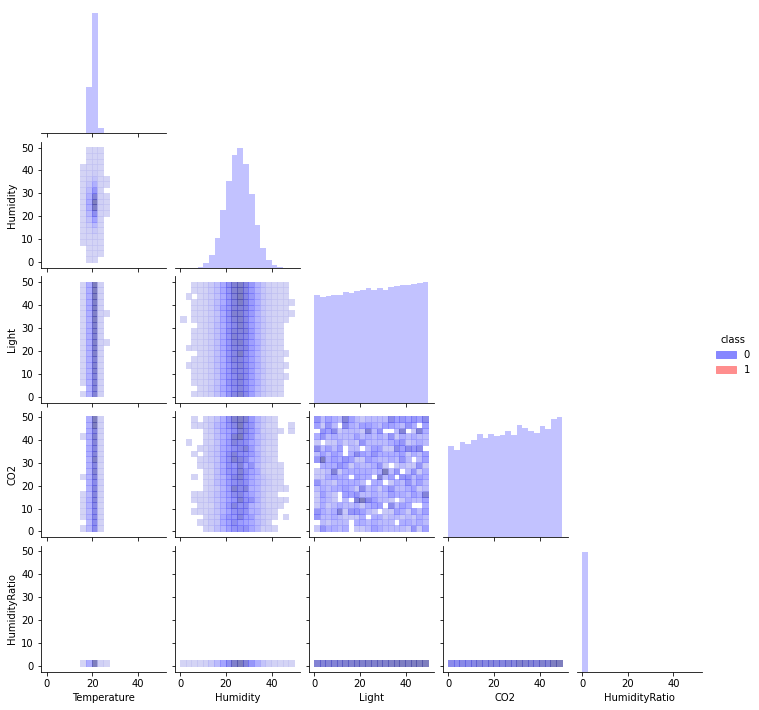

In [30]:
max_nfeatures = len(visualization_original.feature_names)
g = sns.pairplot(visualization_original.df[visualization_original.df["class"]==0], 
                 vars=[var_name for var_name in visualization_original.feature_names[:max_nfeatures]], hue="class", kind="hist", #,markers="s",
                 palette=colors, height=2, corner=True, diag_kws={"linewidth":0, "bins": list(np.linspace(0, 50, num=21))},
                 plot_kws={"linewidths": 0, "edgecolor": "none", "alpha":0.7, "bins": list(np.linspace(0, 50, num=21))}, 
                 ) #.set(xlim=(-2,2), ylim = (-2,2))
plt.show()

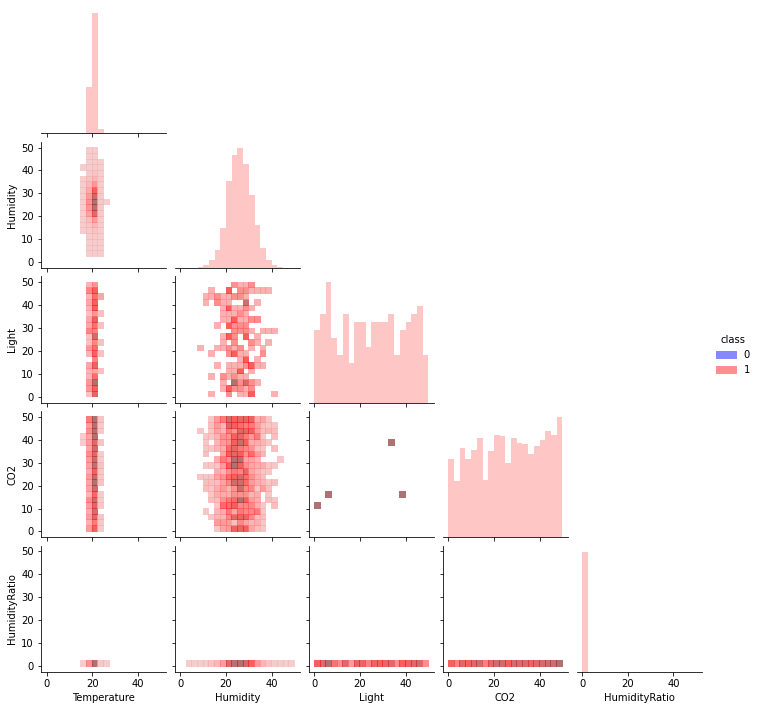

In [32]:
g = sns.pairplot(visualization_original.df[visualization_original.df["class"]==1], 
                 vars=[var_name for var_name in visualization_original.feature_names[:max_nfeatures]], hue="class", kind="hist", #,markers="s",
                 palette=colors, height=2, corner=True, diag_kws={"linewidth":0, "bins": list(np.linspace(0, 50, num=21))},
                 plot_kws={"linewidths": 0, "edgecolor": "none", "alpha":0.7, "bins": list(np.linspace(0, 50, num=21))}, 
                 ) #.set(xlim=(-2,2), ylim = (-2,2))
plt.show()

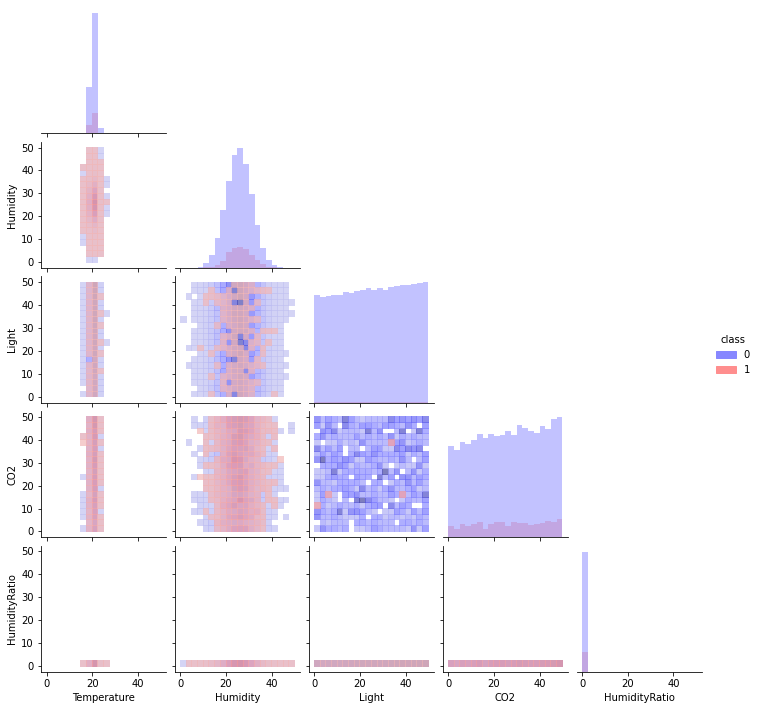

In [33]:
max_nfeatures = len(visualization_original.feature_names)
g = sns.pairplot(visualization_original.df, 
                 vars=[var_name for var_name in visualization_original.feature_names[:max_nfeatures]], hue="class", kind="hist", #,markers="s",
                 palette=colors, height=2, corner=True, diag_kws={"linewidth":0, "bins": list(np.linspace(0, 50, num=21))},
                 plot_kws={"linewidths": 0, "edgecolor": "none", "alpha":0.7, "bins": list(np.linspace(0, 50, num=21))}, 
                 ) #.set(xlim=(-2,2), ylim = (-2,2))
plt.show()

-----
-----

[Index](#Index)  
  
  

----